In [1]:
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
weight = 227
height = 227
channel = 3
autotune = tf.data.experimental.AUTOTUNE
seed = 42

In [3]:
# 데이터 경로 지정
path = './art_classification'

train = os.path.join(path, 'train')
test = os.path.join(path, 'test/0')

In [4]:
# trainset, valset 설정
trainset = tf.keras.preprocessing.image_dataset_from_directory(train, 
                                                           image_size=(weight, height),
                                                           validation_split=.3,
                                                           subset='training',
                                                           seed=seed, batch_size=10)
labels = trainset.class_names
trainset = trainset.cache().prefetch(autotune)

valset = tf.keras.preprocessing.image_dataset_from_directory(train, 
                                                           image_size=(weight, height),
                                                           validation_split=.3,
                                                           subset='validation',
                                                           seed=seed, batch_size=10)
valset = valset.cache().prefetch(autotune)

Found 1698 files belonging to 7 classes.
Using 1189 files for training.
Found 1698 files belonging to 7 classes.
Using 509 files for validation.


In [5]:
# 데이터 Augmentation
augmentor = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip(input_shape = (weight, height, channel)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    ])

In [6]:
# 데이터 정규화
norm = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)

In [7]:
# 모델 생성
vgg16 = tf.keras.applications.VGG16(include_top=False, input_shape=(weight, height, channel))
vgg16.trainable = False

model = tf.keras.Sequential([
    augmentor,
    norm,
    vgg16,
    tf.keras.layers.GlobalAvgPool2D(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

es = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience =30)

model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['acc'])
history = model.fit(trainset, validation_data=valset, epochs=100, callbacks=es)

Epoch 1/100
119/119 [==============================] - 40s 236ms/step - loss: 1.7852 - acc: 0.3263 - val_loss: 1.6080 - val_acc: 0.5049
Epoch 2/100
119/119 [==============================] - 22s 188ms/step - loss: 1.5178 - acc: 0.4727 - val_loss: 1.3793 - val_acc: 0.5953
Epoch 3/100
119/119 [==============================] - 23s 192ms/step - loss: 1.3542 - acc: 0.5324 - val_loss: 1.2331 - val_acc: 0.6189
Epoch 4/100
119/119 [==============================] - 23s 191ms/step - loss: 1.2405 - acc: 0.5694 - val_loss: 1.1417 - val_acc: 0.6306
Epoch 5/100
119/119 [==============================] - 23s 193ms/step - loss: 1.1712 - acc: 0.5854 - val_loss: 1.0677 - val_acc: 0.6621
Epoch 6/100
119/119 [==============================] - 23s 191ms/step - loss: 1.0926 - acc: 0.6106 - val_loss: 1.0119 - val_acc: 0.6640
Epoch 7/100
119/119 [==============================] - 23s 191ms/step - loss: 1.0511 - acc: 0.6316 - val_loss: 0.9735 - val_acc: 0.6798
Epoch 8/100
119/119 [===========================

In [8]:
# Accuracy와 Loss 그래프로 시각화
def graph_show(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Acc vs Val_Acc')
    plt.plot(epochs, acc, label = 'acc')
    plt.plot(epochs, val_acc, label = 'val_acc')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Loss vs Val_Loss')
    plt.plot(epochs, loss, label = 'loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.legend()

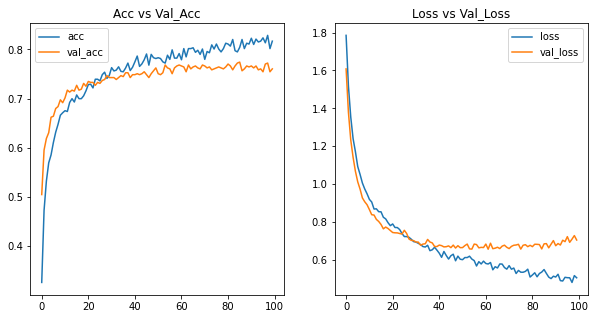

In [9]:
graph_show(history)

In [10]:
# testset 설정
test_dir = os.listdir(test)

In [11]:
def im_show(file_name):
    image_dir = os.path.join(test, file_name)
    image = tf.image.decode_jpeg(tf.io.read_file(image_dir))
    plt.imshow(image)

In [12]:
# 결과 예측
def pred(file_name):
    image_dir = os.path.join(test, file_name)
    image = tf.image.decode_jpeg(tf.io.read_file(image_dir))
    arr = tf.keras.preprocessing.image.img_to_array(image)
    arr_exp = tf.expand_dims(arr, axis = 0)
    
    prediction = model.predict(arr_exp)
    score = tf.nn.softmax(prediction[0])
    result = np.argmax(score)
    
    return result, labels[result]

(None, (5, 'house'))

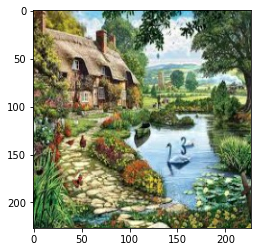

In [14]:
im_show(test_dir[200]), pred(test_dir[200])

In [15]:
# 결과 예측
answer = []
for i in test_dir:
    result, label = pred(i)
    answer.append(result)

In [16]:
# 결과값 데이터프레임으로 만들기
answer = pd.DataFrame(answer, columns=['answer value'])
answer.head(5)

,answer value
0,6
1,3
2,3
3,3
4,4


In [17]:
# csv 파일로 저장
answer.to_csv('submission.csv')